In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [2]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

In [4]:
training_raw = pd.read_csv('../../../DATA/FINAL/training_sample.csv')
testing_raw = pd.read_csv('../../../DATA/FINAL/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 101), (1797, 101))

In [5]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [7]:
mean_values = dict()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        subset_training = training_raw.query('sal_class == @sal_class and sknace_division == @sknace')
        segment_mean_values = dict()
        for col in RATIOS:
            mean_value = subset_training[col].mean()
            # if np.isnan(mean_value): print(sal_class, sknace, col)
            segment_mean_values[col] = mean_value
        
        mean_values[(sal_class, sknace)] = segment_mean_values
    


In [8]:

training_filled = pd.DataFrame()
testing_filled = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        subset_training = training_raw.query('sal_class == @sal_class and sknace_division_normalized == @sknace')
        subset_testing = testing_raw.query('sal_class == @sal_class and sknace_division_normalized == @sknace')
        segment_mean_values = mean_values[(sal_class, sknace)]

        for col in RATIOS:
            mean_value = segment_mean_values[col]
            subset_training[col] = subset_training[col].fillna(mean_value).fillna(0)
            subset_testing[col] = subset_testing[col].fillna(mean_value).fillna(0)

        training_filled = pd.concat([training_filled, subset_training], axis = 0)
        testing_filled = pd.concat([testing_filled, subset_testing], axis = 0)

C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_20848\3606993.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_training[col] = subset_training[col].fillna(mean_value).fillna(0)
C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_20848\3606993.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_testing[col] = subset_testing[col].fillna(mean_value).fillna(0)


In [9]:

from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score
from imblearn.metrics import specificity_score



def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Random Forest Classifier

In [10]:
FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

In [11]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline



Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[FINAL_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[FINAL_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values



# X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
#     X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Assuming X_train_valid_imbalanced and y_train_valid_imbalanced are already defined
# Count the number of samples in each class
counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

# Calculate the number of samples needed for the majority class (class 0) to achieve a 3:2 ratio
minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

# Define the sampling strategy for RandomUnderSampler
sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

# Apply RandomUnderSampler with the defined sampling strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)



Original class distribution: Counter({0.0: 5183, 1.0: 567})


In [20]:

from sklearn.preprocessing import RobustScaler
from scipy.stats import mstats

# Logarithmic Transformation
epsilon = 1e-10
X_train_balanced_log = np.log1p(X_train_balanced + epsilon)
X_test_balanced_log = np.log1p(X_test_balanced + epsilon)
X_train_imbalanced_log = np.log1p(X_train_imbalanced + epsilon)
X_test_imbalanced_log = np.log1p(X_test_imbalanced + epsilon)
X_train_valid_imbalanced_log = np.log1p(X_train_valid_imbalanced + epsilon)
X_valid_valid_imbalanced_log = np.log1p(X_valid_valid_imbalanced + epsilon)

# Winsorizing
X_train_balanced_winsor = mstats.winsorize(X_train_balanced, limits=[0.05, 0.05])
X_test_balanced_winsor = mstats.winsorize(X_test_balanced, limits=[0.05, 0.05])
X_train_imbalanced_winsor = mstats.winsorize(X_train_imbalanced, limits=[0.05, 0.05])
X_test_imbalanced_winsor = mstats.winsorize(X_test_imbalanced, limits=[0.05, 0.05])
X_train_valid_imbalanced_winsor = mstats.winsorize(X_train_valid_imbalanced, limits=[0.05, 0.05])
X_valid_valid_imbalanced_winsor = mstats.winsorize(X_valid_valid_imbalanced, limits=[0.05, 0.05])

# Robust Scaler
scaler = RobustScaler()

X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_balanced_scaled = scaler.transform(X_test_balanced)
X_train_imbalanced_scaled = scaler.fit_transform(X_train_imbalanced)
X_test_imbalanced_scaled = scaler.transform(X_test_imbalanced)
X_train_valid_imbalanced_scaled = scaler.fit_transform(X_train_valid_imbalanced)
X_valid_valid_imbalanced_scaled = scaler.transform(X_valid_valid_imbalanced)

C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_20848\346202962.py:6: RuntimeWarning: invalid value encountered in log1p
  X_train_balanced_log = np.log1p(X_train_balanced + epsilon)
C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_20848\346202962.py:7: RuntimeWarning: invalid value encountered in log1p
  X_test_balanced_log = np.log1p(X_test_balanced + epsilon)
C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_20848\346202962.py:8: RuntimeWarning: invalid value encountered in log1p
  X_train_imbalanced_log = np.log1p(X_train_imbalanced + epsilon)
C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_20848\346202962.py:9: RuntimeWarning: invalid value encountered in log1p
  X_test_imbalanced_log = np.log1p(X_test_imbalanced + epsilon)
C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_20848\346202962.py:10: RuntimeWarning: invalid value encountered in log1p
  X_train_valid_imbalanced_log = np.log1p(X_train_valid_imbalanced + epsilon)
C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_2084

In [21]:
print('\nTEST')
print(pd.Series(y_test_balanced).value_counts())
print(pd.Series(y_test_imbalanced).value_counts())

print('\nTRAIN')
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_imbalanced).value_counts())

print('\nTRAIN W VALID')
print(pd.Series(y_train_valid_balanced).value_counts())
print(pd.Series(y_train_valid_imbalanced).value_counts())

print('\nVALID')
print(pd.Series(y_valid_valid_imbalanced).value_counts())


TEST
0.0    258
1.0    172
dtype: int64
0.0    1625
1.0     172
dtype: int64

TRAIN
0.0    1050
1.0     700
dtype: int64
0.0    6488
1.0     700
dtype: int64

TRAIN W VALID
0.0    850
1.0    567
dtype: int64
0.0    5183
1.0     567
dtype: int64

VALID
0.0    1305
1.0     133
dtype: int64


In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
from sklearn.neural_network import MLPClassifier

# # Define the parameter grid for MLP
# param_grid = {
#     'hidden_layer_sizes':[
#         (13,),
#         (3, 3), (4, 3),
#         (5, 5), (5, 4), (5, 3),
#         (7, 5),
#         (9, 5)
#     ],
#     'activation': ['tanh', 'relu'],
#     'solver': ['adam'],
#     'alpha': [0.00001, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.1],
#     'learning_rate': ['constant', 'adaptive'],
# }



# Define the parameter grid for MLP
param_grid = {
    'hidden_layer_sizes':[
        (4, 4), (4, 3), (4, 2),
        (5, 5), (5, 4), (5, 3), (5, 2)
    ],
    'activation': ['tanh'],
    'solver': ['adam'],
    'alpha': [1e-05, 0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 500, 1000, 2000]
}


# Create an MLP classifier
mlp_classifier = MLPClassifier(random_state=37)

grid_search = GridSearchCV(estimator=mlp_classifier, param_grid=param_grid, cv=5, n_jobs=4, verbose=10, scoring='f1')
grid_search.fit(X_train_balanced_scaled, y_train_balanced)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=37), n_jobs=4,
             param_grid={'activation': ['tanh'], 'alpha': [1e-05, 0.0001],
                         'hidden_layer_sizes': [(4, 4), (4, 3), (4, 2), (5, 5),
                                                (5, 4), (5, 3), (5, 2)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200, 500, 1000, 2000],
                         'solver': ['adam']},
             scoring='f1', verbose=10)

In [24]:
grid_search.best_params_

{'activation': 'tanh',
 'alpha': 1e-05,
 'hidden_layer_sizes': (5, 3),
 'learning_rate': 'constant',
 'max_iter': 200,
 'solver': 'adam'}

In [26]:
# Extract grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display grid search results
# print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Sort by rank to see the best combinations first
sorted_cv_results = cv_results.query('mean_test_score >= 0.60').sort_values(by='rank_test_score')
sorted_cv_results.head(40)




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
51,0.999694,0.010422,0.007186,0.007661,tanh,0.00001,"(5, 3)",constant,200,adam,"{'activation': 'tanh', 'alpha': 1e-05, 'hidden...",0.682171,0.638132,0.656604,0.624060,0.631148,0.646423,0.020898,1
56,1.005976,0.033108,0.000000,0.000000,tanh,0.00001,"(5, 3)",adaptive,200,adam,"{'activation': 'tanh', 'alpha': 1e-05, 'hidden...",0.682171,0.638132,0.656604,0.624060,0.631148,0.646423,0.020898,1
121,0.958034,0.036964,0.003285,0.006570,tanh,0.0001,"(5, 3)",constant,200,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.682171,0.635659,0.656604,0.621723,0.633745,0.645980,0.021294,3
126,0.976570,0.045009,0.000000,0.000000,tanh,0.0001,"(5, 3)",adaptive,200,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.682171,0.635659,0.656604,0.621723,0.633745,0.645980,0.021294,3
116,1.011950,0.035109,0.007937,0.006941,tanh,0.0001,"(5, 4)",adaptive,200,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.664122,0.622047,0.644928,0.646617,0.648221,0.645187,0.013456,5
111,1.005733,0.022077,0.000400,0.000490,tanh,0.0001,"(5, 4)",constant,200,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.664122,0.622047,0.644928,0.646617,0.648221,0.645187,0.013456,5
117,1.213650,0.143706,0.006903,0.008055,tanh,0.0001,"(5, 4)",adaptive,500,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.666667,0.608696,0.657040,0.641509,0.648221,0.644427,0.019765,7
118,1.226808,0.202851,0.000000,0.000000,tanh,0.0001,"(5, 4)",adaptive,1000,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.666667,0.608696,0.657040,0.641509,0.648221,0.644427,0.019765,7
119,1.185798,0.175129,0.003729,0.006506,tanh,0.0001,"(5, 4)",adaptive,2000,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.666667,0.608696,0.657040,0.641509,0.648221,0.644427,0.019765,7
113,1.270972,0.203257,0.003523,0.006557,tanh,0.0001,"(5, 4)",constant,1000,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.666667,0.608696,0.657040,0.641509,0.648221,0.644427,0.019765,7


In [43]:
head = cv_results.query('mean_test_score >= 0.67 and std_test_score < 0.02').head(8)


new_params = dict()

for param_name in cv_results.columns:
    if 'param_' in param_name:
        new_params[param_name] = list(head[param_name].unique())

display(new_params)      


{'param_activation': ['tanh'],
 'param_alpha': [1e-05],
 'param_hidden_layer_sizes': [(3, 3), (5, 3)],
 'param_learning_rate': ['constant', 'adaptive'],
 'param_max_iter': [1000, 2000, 500],
 'param_solver': ['adam']}

## VALIDATION

In [44]:
pd.Series(y_valid_valid_imbalanced).value_counts()

0.0    1305
1.0     133
dtype: int64

In [45]:
def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

real_positives = 133.0, total = 1438
SEMIFINAL MODEL IMBALANCED Accuracy: 0.8379694019471489
SEMIFINAL MODEL IMBALANCED Precision: 0.29838709677419356
SEMIFINAL MODEL IMBALANCED Recall: 0.556390977443609
SEMIFINAL MODEL IMBALANCED Specificity: 0.8666666666666667
SEMIFINAL MODEL IMBALANCED F1 Score: 0.38845144356955374


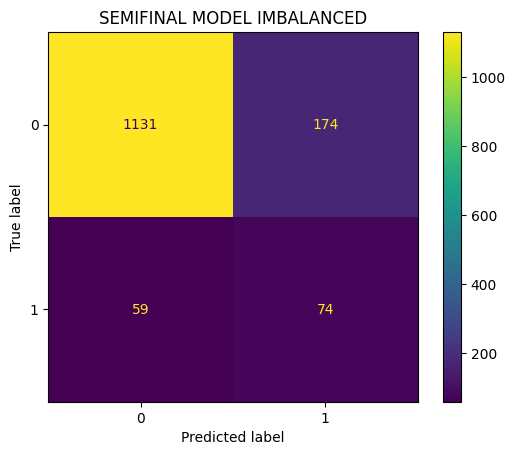

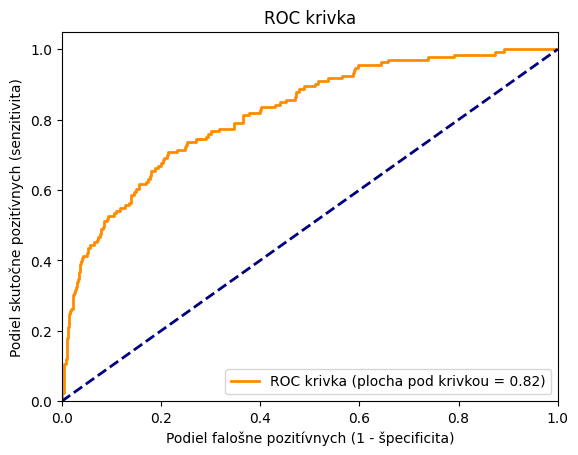

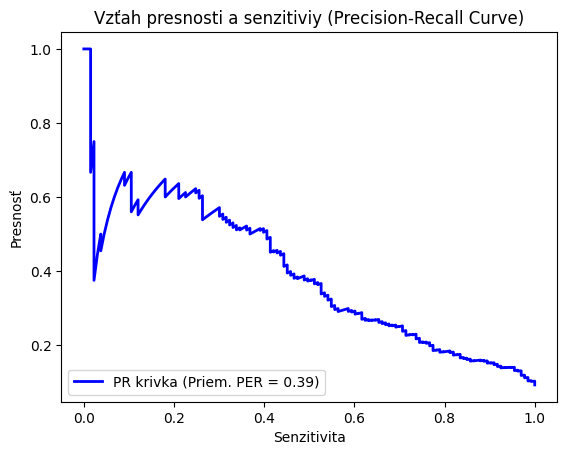

Threshold for 70% recall: 0.056409393513798915
Actual recall: 1.00
real_positives = 133.0, total = 1438
FINAL MODEL IMBALANCED Accuracy: 0.7795549374130737
FINAL MODEL IMBALANCED Precision: 0.25
FINAL MODEL IMBALANCED Recall: 0.6917293233082706
FINAL MODEL IMBALANCED Specificity: 0.7885057471264367
FINAL MODEL IMBALANCED F1 Score: 0.36726546906187624


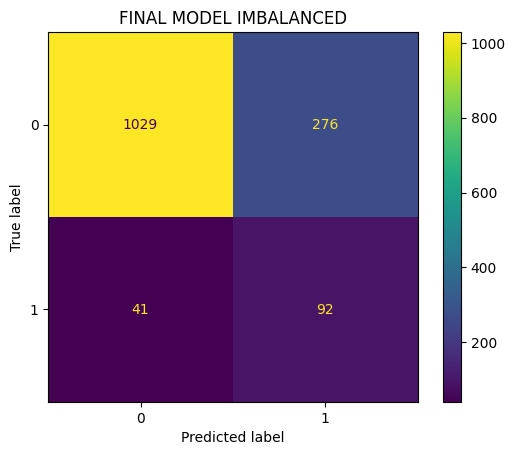

In [50]:

# Create an XGBoost classifier

mlp_classifier = MLPClassifier(
    random_state=37,
    activation= 'tanh',
    alpha = 1e-05,
    hidden_layer_sizes = (5, 3),
    learning_rate = 'constant',
    max_iter = 500,
    solver = 'adam'
    )


mlp_classifier.fit(X_train_valid_balanced, y_train_valid_balanced)

eval(y_valid_valid_imbalanced, mlp_classifier.predict(X_valid_valid_imbalanced), 'SEMIFINAL MODEL IMBALANCED')

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

y_probs = mlp_classifier.predict_proba(X_valid_valid_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid_valid_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_valid_valid_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych (1 - špecificita)')
plt.ylabel('Podiel skutočne pozitívnych (senzitivita)')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid_valid_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_valid_valid_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()




# Find the threshold that achieves the target recall (70%)
target_recall = 0.70
threshold = thresholds[np.argmax(recall >= target_recall)]

# Predict using the new threshold
y_pred = (y_probs >= threshold).astype(int)

# Calculate the recall score with the new threshold
actual_recall = recall_score(y_valid_valid_imbalanced, y_pred)


print(f"Threshold for 70% recall: {threshold}")
print(f"Actual recall: {actual_recall:.2f}")




eval(y_valid_valid_imbalanced, predict_w_threshold(mlp_classifier, X_valid_valid_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

## FINAL TESTING

real_positives = 700.0, total = 1750
FINAL MODEL TRAIN BALANCED Accuracy: 0.7697142857142857
FINAL MODEL TRAIN BALANCED Precision: 0.7454545454545455
FINAL MODEL TRAIN BALANCED Recall: 0.6442857142857142
FINAL MODEL TRAIN BALANCED Specificity: 0.8533333333333334
FINAL MODEL TRAIN BALANCED F1 Score: 0.6911877394636015


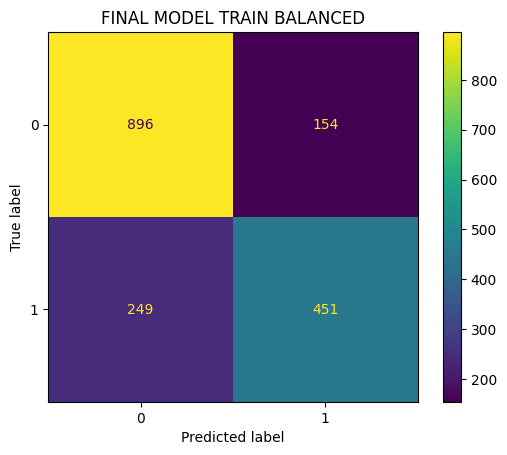

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7232558139534884
FINAL MODEL BALANCED Precision: 0.673202614379085
FINAL MODEL BALANCED Recall: 0.5988372093023255
FINAL MODEL BALANCED Specificity: 0.8062015503875969
FINAL MODEL BALANCED F1 Score: 0.6338461538461538


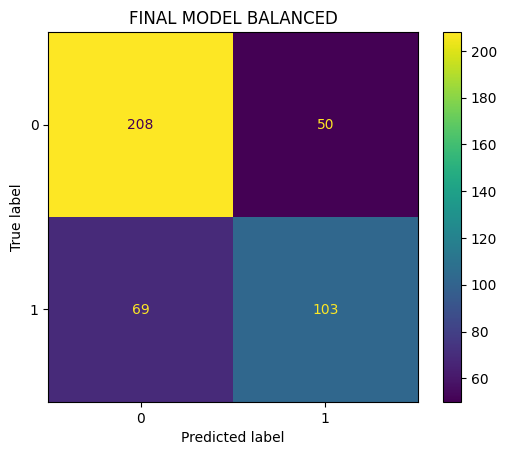

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.8024485253199778
FINAL MODEL IMBALANCED Precision: 0.2647814910025707
FINAL MODEL IMBALANCED Recall: 0.5988372093023255
FINAL MODEL IMBALANCED Specificity: 0.824
FINAL MODEL IMBALANCED F1 Score: 0.3672014260249554


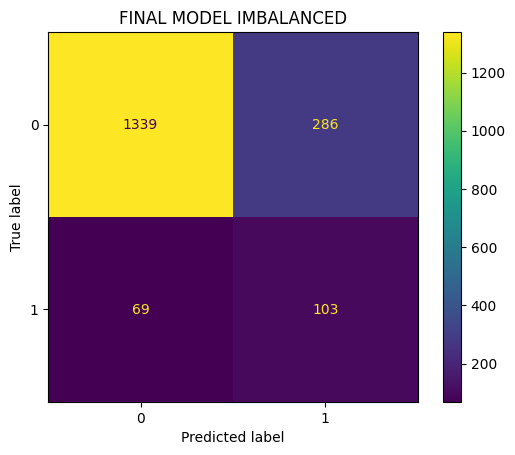

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.713953488372093
FINAL MODEL BALANCED Precision: 0.6296296296296297
FINAL MODEL BALANCED Recall: 0.6918604651162791
FINAL MODEL BALANCED Specificity: 0.7286821705426356
FINAL MODEL BALANCED F1 Score: 0.6592797783933518


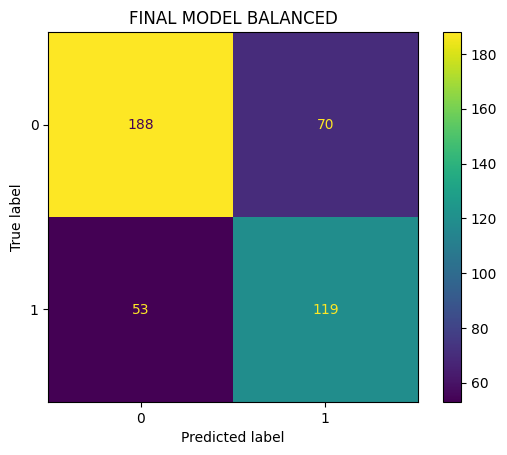

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7401224262659989
FINAL MODEL IMBALANCED Precision: 0.22326454033771106
FINAL MODEL IMBALANCED Recall: 0.6918604651162791
FINAL MODEL IMBALANCED Specificity: 0.7452307692307693
FINAL MODEL IMBALANCED F1 Score: 0.33758865248226955


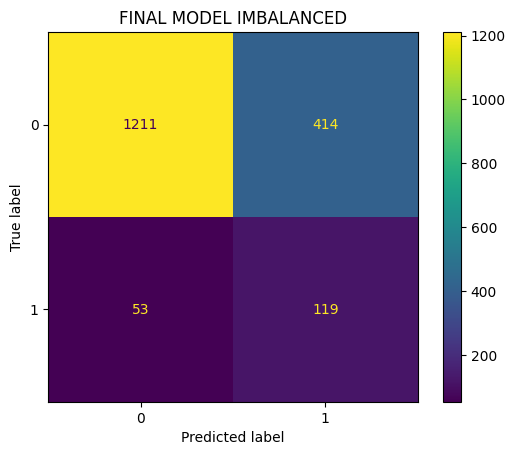

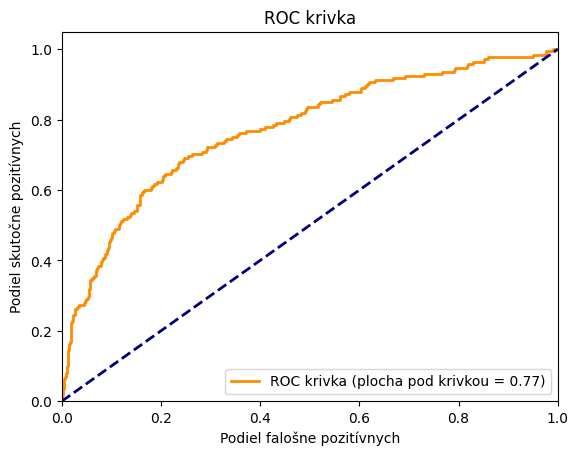

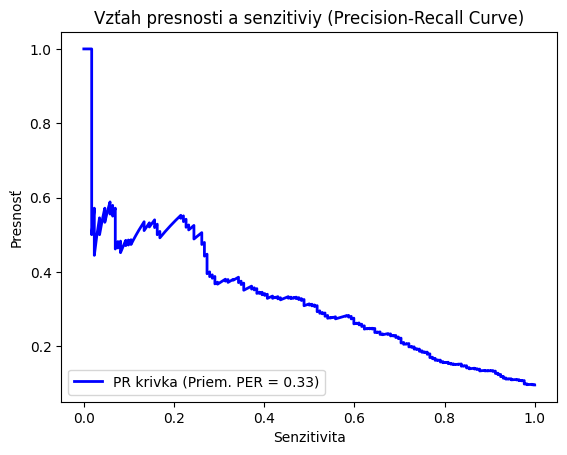

In [51]:
rf_final = MLPClassifier(
    random_state=37,
    activation= 'tanh',
    alpha = 1e-05,
    hidden_layer_sizes = (5, 3),
    learning_rate = 'constant',
    max_iter = 500,
    solver = 'adam'
    )

rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_train_balanced, rf_final.predict(X_train_balanced), 'FINAL MODEL TRAIN BALANCED')
eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_test_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()

